<img align="left" width="150px" height="150px" src="https://astra.dk/sites/default/files/DTU%20logo.png" alt="logo"/>
<h1 align="right"> Social Graphs and Interactions (02805)</h1>

<h1 align=center>Social Blade Bot</h1>

In [5]:
import mechanize
import http.cookiejar
import unicodedata
import re
from bs4 import BeautifulSoup

# OS file system
from os import listdir
from os.path import isfile, join

# Data analysis libraries 
import numpy as np
import pandas as pd

# Visualization libraries
%matplotlib inline
from fa2 import ForceAtlas2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
file_name='clean_data'
df_vid = pd.read_csv(safe_file(file_name)['open'],index_col=0)
# List of handles and channel-ids where nan values are found for the video_id
missing_handle = df_vid[df_vid['transcripts'].isnull()].index.to_list()
len(missing_handle)

179

In [2]:
br = mechanize.Browser()
# Enable cookie support for urllib2 
cookiejar = http.cookiejar.LWPCookieJar() 
br.set_cookiejar( cookiejar ) 
# Broser options 
br.set_handle_equiv( True ) 
br.set_handle_gzip( True ) 
br.set_handle_redirect( True ) 
br.set_handle_referer( True ) 
br.set_handle_robots( False ) 
br.set_handle_refresh( mechanize._http.HTTPRefreshProcessor(), max_time = 1 ) 
br.addheaders = [ ( 'User-agent', 'Mozilla/5.0 (compatible;MSIE 8.0; Windows 98;)')] 

In [3]:
# backup data system
def safe_file(file_name):
    mypath = '.' # current folder
    dbfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and file_name in f]
    max_index = max([int(f[len(file_name):f.index('.')]) for f in dbfiles if f[len(file_name):f.index('.')]])
    open_file = file_name+str(max_index)+'.csv'
    save_file = file_name+str(max_index+1)+'.csv'
    return {'open':open_file,'save':save_file}

In [12]:
categories = ['autos',
'comedy',
'education',
'entertainment',
'film',
'games',
'howto',
'music',
'news',
'nonprofit',
'people',
'animals',
'tech',
'shows',
'sports',
'travel']
#categories = ['tech']

In [13]:

def get_sb_to_channels_from_url(url):
    "INPUT: social blade url where there is a list of top channels"
    "OUTPUT: list of social blade channel id. NOT youtube channel id"
    br.open(url)
    b = br.response().read()
    br.response().close()
    text = str(b,'UTF-8','ignore')
    text = unicodedata.normalize("NFKD", text)
    #text = text.replace(' ',unichr(160));
    #text = text.replace(' ','%C2%A0')

    links_to = re.findall(r'\/youtube\/((?:c|user|channel)\/[^"]+)"', text)
    return links_to


In [14]:
links_to = []
for category in categories:
    print(category)
    links = get_sb_to_channels_from_url(f'https://socialblade.com/youtube/top/category/{category}/mostsubscribed')
    print(len(links))
    links_to += links

autos
250
comedy
250
education
250
entertainment
250
film
250
games
250
howto
250
music
250
news
250
nonprofit
250
people
250
animals
250
tech
250
shows
240
sports
250
travel
250


In [15]:
len(links_to)

3990

In [16]:
def remove_ordinal(string):
    string = string.replace('st','').replace('nd','').replace('rd','').replace('th','')
    return string

In [17]:
def sb_ch_id_to_yt_ch_id(sb_list):
    channels_data = []
    c = 0
    c_total = len(sb_list)
    for link in sb_list:
        try:
            link = link.replace(' ', '%C2%A0')
            #link = urllib.parse.quote(link,encoding='UTF-8',safe='/')
            url = 'https://socialblade.com/youtube/'+link
            br.open(url)
            b = br.response().read()
            br.response().close()
            text = b.decode("UTF-8", 'ignore')
            text = unicodedata.normalize("NFKD", text)
            soup = BeautifulSoup(text, 'html.parser')

            # print(soup.prettify())
            uploads = int(soup.find(id='youtube-stats-header-uploads').string)
            # print(f'Uploads: {uploads}')
            subs = soup.find(id='youtube-stats-header-subs').string
            if 'M' in subs:
                subs = int(float(subs.replace('M',''))*1000000)
            elif 'K' in subs:
                subs = int(float(subs.replace('K',''))*1000)
            # print(f'Subs: {subs}')
            views = int(soup.find(id='youtube-stats-header-views').string)
            # print(f'Views: {views}')
            country = soup.find(id='youtube-stats-header-country').string
            # print(f'Country: {country}')
            topic = soup.find(id='youtube-stats-header-channeltype').string
            # print(f'Topic: {topic}')
            instagram = np.nan
            twitter = np.nan
            facebook = np.nan
            youtube = np.nan
            for elem in soup.find(id='YouTubeUserTopSocial').find_all('a'):
                elem = elem['href']
                if 'instagram' in elem:
                    instagram = elem.split('/')[-1]
                if 'twitter' in elem:
                    twitter = elem.split('/')[-1]
                if 'facebook' in elem:
                    facebook = elem.split('/')[-1]
                if 'youtube' in elem:
                    youtube = elem.split('/')[-1]
            # print(f'Instagram: {instagram}')
            # print(f'Twitter: {twitter}')
            # print(f'Facebook: {facebook}')
            # print(f'Youtube: {youtube}')
            data = soup.find(style='float: right; width: 720px; padding: 10px; background: #fff; border-bottom: 2px solid #e2e2e2;').find_all('p')
            sb_rank = int(remove_ordinal(data[0].string).replace(',',''))
            # print(f'Social Blade Rank: {sb_rank}')
            subs_rank = int(remove_ordinal(data[1].string).replace(',',''))
            # print(f'Subs Rank: {subs_rank}')
            video_views_rank = int(remove_ordinal(data[2].string).replace(',',''))
            # print(f'Video views rank: {video_views_rank}')
            country_rank = int(remove_ordinal(data[3].string).replace(',',''))
            # print(f'Country rank: {country_rank}')
            topic_rank = int(remove_ordinal(data[4].string).replace(',',''))
            # print(f'Category rank: {topic_rank}')
            # print('----------------')
            channel_data = {
                'sb_id':link,
                'uploads':uploads,
                'subs':subs,
                'views':views,
                'country':country,
                'topic':topic,
                'instagram':instagram,
                'twitter':twitter,
                'facebook':facebook,
                'youtube':youtube,
                'sb_rank':sb_rank,
                'subs_rank':subs_rank,
                'video_views_rank':video_views_rank,
                'country_rank':country_rank,
                'topic_rank':topic_rank      
            }
            # user_id.append(re.findall(r'https:\/\/youtube\.com\/((?:channel|user)\/[^"]+)"', text)[0])
            channels_data.append(channel_data)
        except:
            print(f'Error: {link}')
        print(f'{c}/{c_total}')
        c+=1
    return channels_data
channels_data = sb_ch_id_to_yt_ch_id(links_to)

0/3990
1/3990
2/3990
3/3990
4/3990
5/3990
6/3990
7/3990
8/3990
9/3990
10/3990
11/3990
12/3990
Error: c/car%C2%A0wow
13/3990
14/3990
Error: c/ильдаравтоподбор
15/3990
16/3990
Error: c/гараж54
17/3990
18/3990
19/3990
20/3990
21/3990
22/3990
23/3990
24/3990
25/3990
26/3990
27/3990
28/3990
29/3990
30/3990
31/3990
32/3990
33/3990
34/3990
35/3990
Error: c/technicalsunil
36/3990
37/3990
38/3990
39/3990
40/3990
41/3990
42/3990
Error: c/жорикревазов
43/3990
44/3990
45/3990
46/3990
47/3990
48/3990
49/3990
50/3990
51/3990
52/3990
53/3990
54/3990
55/3990
56/3990
57/3990
Error: c/антонворотников
58/3990
59/3990
60/3990
61/3990
62/3990
63/3990
64/3990
65/3990
66/3990
Error: channel/UC11v93uPnHW0YqGxRkaunBA
67/3990
68/3990
69/3990
70/3990
71/3990
72/3990
73/3990
Error: c/العالميةلصيانةالسياراتجدة
74/3990
75/3990
76/3990
77/3990
78/3990
79/3990
80/3990
81/3990
82/3990
83/3990
84/3990
85/3990
Error: c/%C2%A0zpsanek
86/3990
87/3990
88/3990
Error: channel/UC4Uj6bwqnd0DP1-X_k1g5Ew
89/3990
90/3990
91/3990


1463/3990
1464/3990
1465/3990
1466/3990
1467/3990
1468/3990
1469/3990
1470/3990
1471/3990
1472/3990
1473/3990
1474/3990
1475/3990
1476/3990
1477/3990
1478/3990
1479/3990
1480/3990
1481/3990
1482/3990
1483/3990
1484/3990
1485/3990
1486/3990
1487/3990
1488/3990
1489/3990
1490/3990
1491/3990
Error: c/unspeakableplay=s\
1492/3990
1493/3990
1494/3990
1495/3990
1496/3990
1497/3990
1498/3990
1499/3990
1500/3990
1501/3990
1502/3990
Error: channel/UCbrd1vu4_7qIE6IPV_dA-OA
1503/3990
1504/3990
1505/3990
1506/3990
1507/3990
1508/3990
1509/3990
1510/3990
1511/3990
1512/3990
1513/3990
1514/3990
1515/3990
Error: channel/UCu6oyJJ6PlkeNNv6n26ZNyA
1516/3990
1517/3990
1518/3990
1519/3990
1520/3990
1521/3990
1522/3990
1523/3990
1524/3990
1525/3990
1526/3990
1527/3990
Error: c/pauti%C2%A0́ps
1528/3990
1529/3990
1530/3990
1531/3990
1532/3990
1533/3990
1534/3990
1535/3990
1536/3990
1537/3990
1538/3990
1539/3990
1540/3990
1541/3990
1542/3990
1543/3990
1544/3990
1545/3990
Error: channel/UCLEKScK-KhlSC7Nq8UBAa6

2772/3990
Error: channel/UC9z6M5AhkOkAasrl2hKlVAw
2773/3990
2774/3990
2775/3990
2776/3990
2777/3990
2778/3990
Error: channel/UC9LxuffQCm_Z4KBCoXZvSHA
2779/3990
2780/3990
2781/3990
2782/3990
2783/3990
2784/3990
2785/3990
2786/3990
2787/3990
2788/3990
Error: channel/UC9gPwVGWqT8xkArzQ2PB0jA
2789/3990
Error: channel/UCw2W7GIqJNB-UMUxncnMuiw
2790/3990
2791/3990
2792/3990
2793/3990
2794/3990
2795/3990
2796/3990
Error: channel/UCN0B-PI5RXB-3OSwQod6f4w
2797/3990
2798/3990
Error: channel/UCuTSm59-_kap6J7Se-orUVA
2799/3990
Error: c/osmelhorestops
2800/3990
2801/3990
2802/3990
2803/3990
2804/3990
2805/3990
2806/3990
Error: channel/UComwL29zYKujb1JhkB0EcGA
2807/3990
2808/3990
2809/3990
2810/3990
2811/3990
2812/3990
Error: c/robinseplut
2813/3990
2814/3990
2815/3990
2816/3990
2817/3990
2818/3990
2819/3990
Error: c/cocomelontoys
2820/3990
2821/3990
2822/3990
2823/3990
Error: channel/UCR2KG2dK1tAkwZZjm7rAiSg
2824/3990
2825/3990
2826/3990
2827/3990
2828/3990
2829/3990
2830/3990
2831/3990
Error: chann

3352/3990
Error: channel/UCF92-Ek0KxLJE0rhPDGhnGw
3353/3990
Error: channel/UC7XNh8i5xxUTVROyo9yRstg
3354/3990
3355/3990
Error: user/nickelodeonplayca
3356/3990
3357/3990
Error: channel/UCJSS7rHjYTOpzo9kHTJQBZg
3358/3990
Error: user/cookingchannelshows
3359/3990
Error: user/alliancefilmsus
3360/3990
3361/3990
3362/3990
Error: channel/UCG34EqcgG_kVgZbhVOBeY2g
3363/3990
Error: channel/UCuQbZwupzg4KWzMWn0DceAg
3364/3990
Error: user/comedycentralplayca
3365/3990
Error: user/alivemind
3366/3990
3367/3990
Error: user/echobridgeentfilms
3368/3990
3369/3990
3370/3990
Error: user/shopamc
3371/3990
3372/3990
Error: channel/UCHIUnP7aVA-hXmXdYW9vB5A
3373/3990
3374/3990
Error: user/ukcartoonnetwork
3375/3990
Error: channel/UCjJzyFJaWc-ocICgxFjblog
3376/3990
Error: user/arrowfilmsvod
3377/3990
3378/3990
Error: user/militaryfullepisodes
3379/3990
Error: user/ifcshop
3380/3990
Error: user/gaiamfitus
3381/3990
Error: user/mtvplayau
3382/3990
Error: channel/UCG4mFTSwmd90G8VGgCC4s2Q
3383/3990
Error: user/

3755/3990
3756/3990
Error: c/tobyturner%c2%a8
3757/3990
3758/3990
3759/3990
3760/3990
3761/3990
3762/3990
3763/3990
3764/3990
3765/3990
3766/3990
3767/3990
3768/3990
3769/3990
3770/3990
3771/3990
3772/3990
3773/3990
3774/3990
3775/3990
Error: c/蔡阿嘎life
3776/3990
3777/3990
3778/3990
3779/3990
3780/3990
3781/3990
3782/3990
Error: c/rachelniko
3783/3990
3784/3990
3785/3990
3786/3990
3787/3990
3788/3990
3789/3990
3790/3990
3791/3990
3792/3990
3793/3990
3794/3990
3795/3990
3796/3990
3797/3990
3798/3990
3799/3990
3800/3990
3801/3990
3802/3990
3803/3990
3804/3990
3805/3990
3806/3990
3807/3990
3808/3990
3809/3990
3810/3990
3811/3990
3812/3990
3813/3990
3814/3990
3815/3990
Error: channel/UCHpIHu4LzmNuD8bsE6mZLSA
3816/3990
3817/3990
3818/3990
3819/3990
3820/3990
3821/3990
3822/3990
3823/3990
3824/3990
3825/3990
3826/3990
3827/3990
3828/3990
3829/3990
3830/3990
3831/3990
3832/3990
3833/3990
3834/3990
3835/3990
3836/3990
3837/3990
3838/3990
3839/3990
3840/3990
3841/3990
3842/3990
3843/3990
3844/39

In [10]:
tech_df = pd.DataFrame(channels_data)
tech_df.set_index('sb_id',inplace=True)

In [11]:
tech_df

uploads      subs       views country topic  \
sb_id                                                                           
c/unboxtherapy                       1706  15800000  3303912805      CA  tech   
c/technicalguruji                    2659  14600000  1496122643      IN  tech   
c/manualdomundo                      1526  12800000  2233891509      BR  tech   
c/crazyrussianhacke                  1442  11200000  2692080764      US  tech   
c/mrgearofficial                      674  10400000  2673100238      RU  tech   
...                                   ...       ...         ...     ...   ...   
c/garritv                             177   1160000   130434524      RU  tech   
channel/UCudQoTP7Jo9jkTNoo1X8rvw     1075   1150000   187438174      SA  tech   
c/phonebuff                           614   1150000   251706869      US  tech   
c/tuahraja%C2%A0                      224   1140000   267086763      ID  tech   
c/tecnodia                           6397   1140000   149309897      BR  tech   

                                           instagram          twitter  \
sb_id                                                                   
c/unboxtherapy                          unboxtherapy     unboxtherapy   
c/technicalguruji                    technicalguruji  technicalguruji   
c/manualdomundo                         amarifulfaro      marifulfaro   
c/crazyrussianhacke               crazyrussianhacker              NaN   
c/mrgearofficial                                 NaN              NaN   
...                                              ...              ...   
c/garritv                                    garritv           1garri   
channel/UCudQoTP7Jo9jkTNoo1X8rvw                 NaN              NaN   
c/phonebuff                                phonebuff        phonebuff   
c/tuahraja%C2%A0                                 NaN        tuah_raja   
c/tecnodia                                  tecnodia        tecno_dia   

                                            facebook  \
sb_id                                                  
c/unboxtherapy                          unboxtherapy   
c/technicalguruji                    technicalguruji   
c/manualdomundo                                        
c/crazyrussianhacke               CrazyRussianHacker   
c/mrgearofficial                                 NaN   
...                                              ...   
c/garritv                                              
channel/UCudQoTP7Jo9jkTNoo1X8rvw                 NaN   
c/phonebuff                                phonebuff   
c/tuahraja%C2%A0                        usertuahraja   
c/tecnodia                                  TecnoDia   

                                                   youtube   sb_rank  \
sb_id                                                                  
c/unboxtherapy                    UCsTcErHg8oDvUnTzoqsYeNw       722   
c/technicalguruji                 UCOhHO2ICt0ti9KAh-QHvttQ      1488   
c/manualdomundo                   UCKHhA5hN2UohhFDfNXB_cvQ      5480   
c/crazyrussianhacke               UCe_vXdMrHHseZ_esYUskSBw      9078   
c/mrgearofficial                  UCo6DJdltbIub80bLiyJRv3w  31733490   
...                                                    ...       ...   
c/garritv                         UCBB55e_DdXkLyiG65Acj28Q    216576   
channel/UCudQoTP7Jo9jkTNoo1X8rvw  UCudQoTP7Jo9jkTNoo1X8rvw     38152   
c/phonebuff                       UChYU73igK5wQhWAXPh3X8PA     14025   
c/tuahraja%C2%A0                  UCwUd5rSyEflGoM3ReV_CaYg     27335   
c/tecnodia                        UCF0D_UqctII0xI0q-IbctUA     95675   

                                  subs_rank  video_views_rank  country_rank  \
sb_id                                                                         
c/unboxtherapy                          199               593             7   
c/technicalguruji                       245              1762            33   
c/manualdomundo                         308     

In [22]:
total_df = pd.DataFrame(channels_data)
total_df.set_index('sb_id',inplace=True)

total_df.to_csv('social_blade_data.csv')

In [45]:
total_df = pd.read_csv('Old/social_blade_data.csv')

In [49]:
country = total_df.groupby(['country']).size().sort_values()

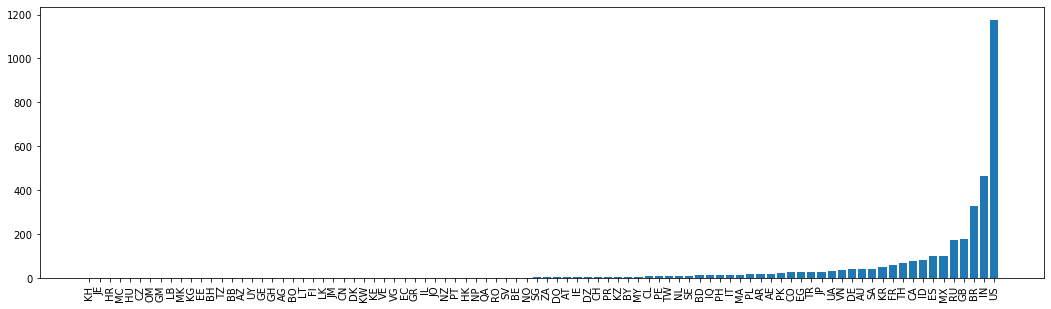

In [50]:
plt.figure(figsize=(18,5))
plt.bar(country.index,country.values)
plt.xticks(rotation=90)
plt.show()

In [21]:
len(total_df[total_df['twitter'].notnull()])

2148

In [22]:
len(total_df[total_df['instagram'].notnull()])

1188

In [23]:
len(total_df[total_df['facebook'].notnull()])

2108

In [24]:
len(total_df[total_df['youtube'].notnull()])

3559

In [25]:
len(total_df)

3562

In [33]:
len(total_df[total_df['country']=='US'])

1177

In [47]:
len(total_df[(total_df['twitter'].notnull())&(total_df['youtube'].notnull())&(total_df['country'].isin(['US','GB']))])

937

In [51]:
total_df[(total_df['twitter'].notnull())&(total_df['youtube'].notnull())&(total_df['country'].isin(['US','GB']))].groupby('topic').size()

topic
animals           39
autos             53
comedy            76
education         53
entertainment     72
film              57
games             82
howto             93
music            108
news              35
nonprofit         43
people            48
shows             14
sports            72
tech              49
travel            43
dtype: int64

In [52]:
df_selected = total_df[(total_df['twitter'].notnull())&(total_df['youtube'].notnull())&(total_df['country'].isin(['US','GB']))]

In [56]:
df_selected.head()

sb_id  uploads       subs         views country  topic  \
0     c/colinfurze    271.0  8590000.0  9.675877e+08      GB  autos   
1        c/topgear   1250.0  6880000.0  2.488229e+09      GB  autos   
2   c/trendchannel   2047.0  6400000.0  1.087566e+09      US  autos   
3      c/chris-fix    322.0  5740000.0  8.159634e+08      US  autos   
10    c/dougdemuro    446.0  3190000.0  8.854144e+08      US  autos   

     instagram      twitter         facebook                   youtube  \
0          NaN  colin_furze  521680751253584  UCp68_FLety0O-n9QU6phsgw   
1          NaN  bbc_topgear          topgear  UCjOl2AUblVmg2rA_cRgZkFg   
2   motortrend   motortrend    motortrendmag  UCsAegdhiYLEoaFGuJFVrqFQ   
3          NaN   ChrisFixed        chrisfix8  UCes1EvRjcKU4sY_UEavndBw   
10         NaN   dougdemuro              NaN  UCsqjHFMB_JYTaEnf_vmTNqg   

    sb_rank  subs_rank  video_views_rank  country_rank  topic_rank  
0   14602.0      663.0            3026.0          38.0         1.0  
1    1557.0      951.0             892.0          51.0         2.0  
2   16332.0     1092.0            2611.0         433.0         3.0  
3    5306.0     1300.0            3760.0         496.0         4.0  
10   4791.0     3299.0            3382.0        1094.0        11.0

In [53]:
df_selected.to_csv('selected_data.csv')

In [55]:
df_twitter = pd.read_csv('twitter_data11.csv')

In [57]:
df_twitter.head()

screen_name                                            friends  \
0     unboxtherapy  ['puri_sm', 'panos_panay', 'microsoftstore', '...   
1  technicalguruji                                                 []   
2      marifulfaro  ['mklausunicef', 'nelsonleoni', 'leoradiofobia...   
3          cdnleon  ['daviddobrik', 'petermckinnon', 'samiabomfim'...   
4            MKBHD  ['jarvis', 'panos_panay', 'supremedreams_1', '...   

                                               links  
0  ['asapscience', 'austinnotduncan', 'c4etech', ...  
1                                                 []  
2                                         ['oatila']  
3  ['austinnotduncan', 'jayztwocents', 'linustech...  
4  ['austinnotduncan', 'detroitborg', 'flossycart...

In [58]:
df_data = pd.merge(df_selected,df_twitter,how='left',left_on='twitter',right_on='screen_name')

In [68]:
df_data['friends'] = df_data['friends'].replace('[]',np.nan)

In [71]:
len(df_data[df_data['friends'].notnull()])

43

In [76]:
df_data.set_index('twitter',inplace=True)

In [77]:
# df_data.to_csv('selected_data1.csv')

In [87]:
df_data = pd.read_csv('selected_data3.csv',index_col=0)
len(eval(df_data.loc['bbc_topgear'].friends))

1807

In [93]:
937-43

894

In [90]:
file_name = 'selected_data'
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

874

In [91]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

869

In [92]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

859

In [94]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

845

In [95]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

841

In [96]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

833

In [106]:
df_friends[df_friends['friends'].notnull()].sample(5)

sb_id  uploads       subs  \
twitter                                                              
phonebuff                          c/phonebuff    614.0  1150000.0   
jayztwocents                   c/jayztwocents\   1291.0  2180000.0   
sharppro                    c/sharpproductions   1199.0   475000.0   
ThemeParkHD                      c/themeparkhd   2763.0   461000.0   
techinsider   channel/UCVLZmDKeT-mV4H3ToYXIFYg   3655.0  2830000.0   

                    views country   topic    instagram          facebook  \
twitter                                                                    
phonebuff     251706869.0      US    tech    phonebuff         phonebuff   
jayztwocents  401638590.0      US    tech          NaN      jayztwocents   
sharppro      320455356.0      US  travel          NaN  sharpproductions   
ThemeParkHD   285956111.0      US  travel  ThemeParkHD               NaN   
techinsider   937542717.0      US    tech          NaN       techinsider   

                               youtube  sb_rank  subs_rank  video_views_rank  \
twitter                                                                        
phonebuff     UChYU73igK5wQhWAXPh3X8PA  14025.0    13124.0           14345.0   
jayztwocents  UCkWQ0gDrqOCarmUKmppD7GQ  14559.0     5711.0            8636.0   
sharppro      UCGsF1XNO_FLgjQtO6RM461A  19778.0    35711.0           11073.0   
ThemeParkHD   UC37BPLRnJzSuPwbV07F2PUQ  37955.0    36842.0           12502.0   
techinsider   UCVLZmDKeT-mV4H3ToYXIFYg  12381.0     3900.0            3147.0   

              country_rank  topic_rank  \
twitter                                  
phonebuff           3619.0       248.0   
jayztwocents        1748.0       110.0   
sharppro            8586.0       156.0   
ThemeParkHD         8833.0       163.0   
techinsider         1263.0        73.0   

                                                        friends  \
twitter                                                           
phonebuff     ['drewbam', 'tomwarren', 'mattcassinelli', 'fi...   
jayztwocents  ['ifixit', 'tldtoday', 'disneycruise', 'femenn...   
sharppro      ['kingsdominionpr', 'nikk0marie', 'randomoasis...   
ThemeParkHD   ['ihiccuptoomuch', 'aliciastella', 'realdonald...   
techinsider   ['btybpod', 'rosaliechan17', 'mannyfidel', 'si...   

                                                          links  
twitter                                                          
phonebuff     ['androidauth', 'austinnotduncan', 'c4etech', ...  
jayztwocents  ['austinnotduncan', 'bitwitkyle', 'hardwarecan...  
sharppro                                                    NaN  
ThemeParkHD                                                 NaN  
techinsider   ['cnet', 'google', 'motherboard', 'nasa', 'ver...

In [102]:
df_friends.drop(columns=['screen_name'],inplace=True)

In [107]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

553

In [135]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

16

In [137]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

1

In [138]:
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)
missing_handle = df_friends[df_friends['friends'].isnull()].index.to_list()
len(missing_handle)

0

- We have to look at the different communities and their propieties becouse we have a biased sample.

In [3]:
file_name = 'selected_data'
df_friends = pd.read_csv(safe_file(file_name)['open'],index_col=0)

In [4]:
df_friends.head()

sb_id  uploads       subs         views country  topic  \
twitter                                                                        
colin_furze    c/colinfurze    271.0  8590000.0  9.675877e+08      GB  autos   
bbc_topgear       c/topgear   1250.0  6880000.0  2.488229e+09      GB  autos   
motortrend   c/trendchannel   2047.0  6400000.0  1.087566e+09      US  autos   
ChrisFixed      c/chris-fix    322.0  5740000.0  8.159634e+08      US  autos   
dougdemuro     c/dougdemuro    446.0  3190000.0  8.854144e+08      US  autos   

              instagram         facebook                   youtube  sb_rank  \
twitter                                                                       
colin_furze         NaN  521680751253584  UCp68_FLety0O-n9QU6phsgw  14602.0   
bbc_topgear         NaN          topgear  UCjOl2AUblVmg2rA_cRgZkFg   1557.0   
motortrend   motortrend    motortrendmag  UCsAegdhiYLEoaFGuJFVrqFQ  16332.0   
ChrisFixed          NaN        chrisfix8  UCes1EvRjcKU4sY_UEavndBw   5306.0   
dougdemuro          NaN              NaN  UCsqjHFMB_JYTaEnf_vmTNqg   4791.0   

             subs_rank  video_views_rank  country_rank  topic_rank  \
twitter                                                              
colin_furze      663.0            3026.0          38.0         1.0   
bbc_topgear      951.0             892.0          51.0         2.0   
motortrend      1092.0            2611.0         433.0         3.0   
ChrisFixed      1300.0            3760.0         496.0         4.0   
dougdemuro      3299.0            3382.0        1094.0        11.0   

            screen_name                                            friends  \
twitter                                                                      
colin_furze         NaN  ['blizzard_ent', 'overwatcheu', 'playoverwatch...   
bbc_topgear         NaN  ['flintoff11', 'paddymcguinness', 'jasonmanfor...   
motortrend          NaN  ['firstwefeast', 'stephencurry30', 'kobebryant...   
ChrisFixed          NaN  ['courtneyforce', 'adam_lz', 'tjhunt_', 'thatd...   
dougdemuro          NaN  ['howsmydrivingdc', 'achantra', 'dcpolicycente...   

                                                         links  
twitter                                                         
colin_furze  ['carthrottle', 'cleanbandit', 'gopro', 'ilike...  
bbc_topgear                            ['fifthgeartv', 'ford']  
motortrend   ['autocar', 'bbc_topgear', 'billgates', 'chevr...  
ChrisFixed   ['adam_lz', 'bbc_topgear', 'caranddriver', 'ca...  
dougdemuro   ['austinnotduncan', 'jasonfenske13', 'lenosgar...

In [57]:
error_list = []
for index,row in df_friends.iterrows():
    try:
        if '[' not in row['friends']:
            error_list.append(row['friends'])
    except:
        pass

In [ ]:
df_error = pd.Series(error_list)
print(len(df_error))
plt.bar(df_error.groupby(df_error).size().index,df_error.groupby(df_error).size().values)
plt.xticks(rotation=90)
plt.show()

192


In [6]:
#df_friends[df_friends['friends'].str.contains('[',case=False)]

- Add Canada and maybe other countries
- Try to get the data for the errors
    - Code 88 may be solved by using tweerpy api
    - For code 34 we should do manual fixing
- Try to download data for empty lists in friends
- Drop screen name
- Add Videos ID per channel
- Add transcripts per channel
- Analysis:
    - Degree Distribution
    - Average degree of the network
    - Random, Watts-Strogatz,Power-laws
    - The friendship paradox
    - Betweenness centrality
    - Eigenvector centrality
    - Outgoing strength distribution
    - Community detection
    - Mixing the network (sune said that)
    - Confusion matrix
    - TF-IDF (provably the code needs revision as we got a low score)
    - Sentiment analysis
    
- Website...